<a href="https://colab.research.google.com/github/Clarkdrengen/PML_2023/blob/main/PML_Part_b_Team_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 15.7 MB/s eta 0:00:00


In [19]:
import arviz
#from numpyro.infer.util import Predictive

import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets
from sklearn import model_selection

import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.infer.mcmc as HMC
import pyro.distributions as dist

import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo

In [100]:
pyro.set_rng_seed(1)
n = 1000
X = torch.linspace(-1.0, 1.0, n) 

def func(X):
  return np.sin(20*X) + 2*np.cos(14*X) - 2*np.sin(6*X)

In [161]:
x = torch.linspace(-1.0, 1.0, 5)
y = func(x)

In [102]:
## normalize data to zero mean
#mean, var = torch.mean(y), torch.var(y)
#y  = (y-mean)/var

In [103]:
kernel = gp.kernels.RBF(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
gpr = gp.models.GPRegression(x, y, kernel)

In [109]:
hmc_kernel=pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=5000, num_chains=5, warmup_steps=5000)
mcmc.run()
posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_vs = mcmc.get_samples()["kernel.variance"]

/usr/local/lib/python3.8/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=5 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Warmup:   0%|          | 0/10000 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/10000 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(

In [110]:
samples = mcmc.get_samples()

In [111]:
az_data = arviz.from_pyro(posterior=mcmc)
summary = arviz.summary(az_data)
summary

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.lengthscale,0.614,0.711,0.009,1.695,0.006,0.004,16236.0,15178.0,1.0
kernel.variance,2.382,4.144,0.000,6.907,0.033,0.023,15863.0,11416.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9d56f0730>,
      dtype=object)

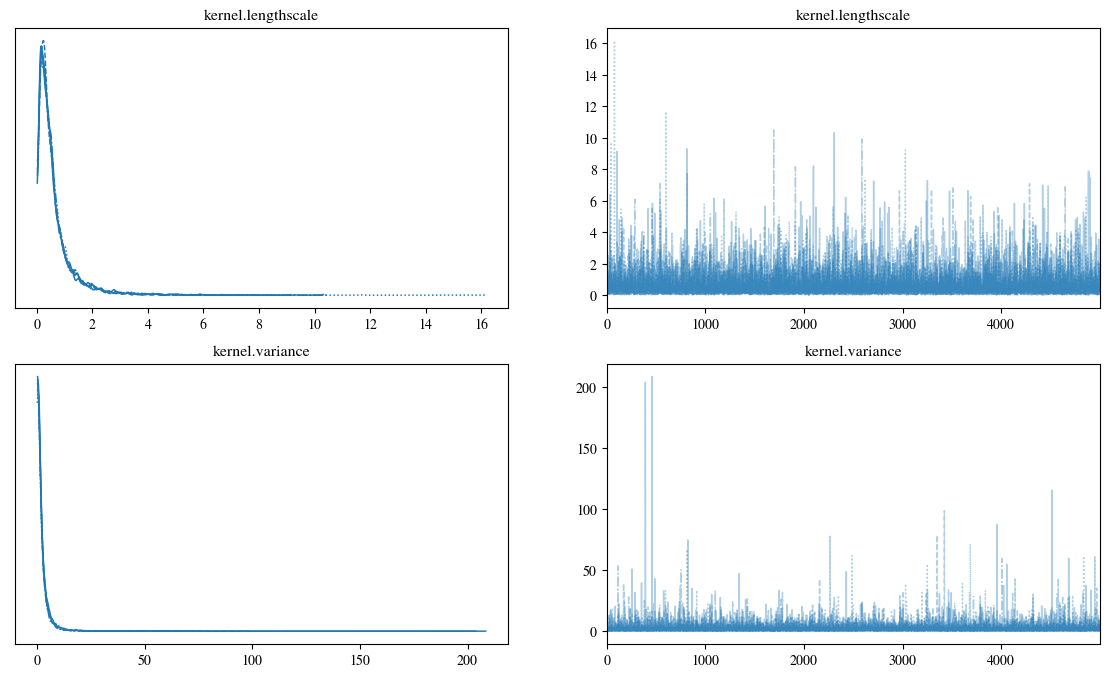

In [112]:
from numpy.core.fromnumeric import size
arviz.plot_trace(az_data, figsize=(14, 8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9d552da00>,
      dtype=object)

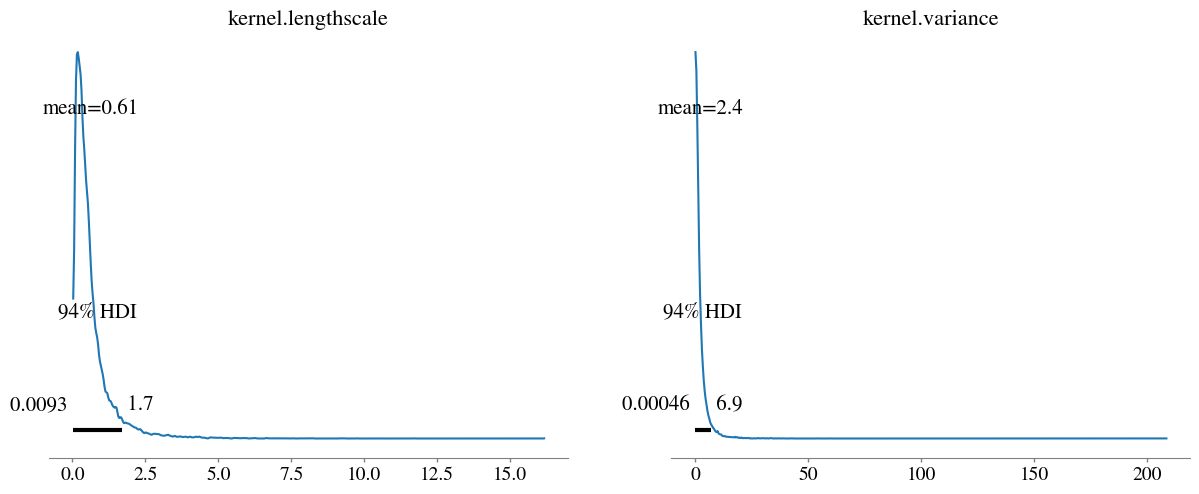

In [113]:
arviz.plot_posterior(az_data)

# Create log/log scatter plot of 500 samples from the posterior $p(θ|\mathcal{D})$

In [114]:
import random
idx = random.sample(range(1000), 500)
post_len = []
for i in idx:
  post_len.append(posterior_ls[i])

post_var = []
for i in idx:
  post_var.append(posterior_vs[i])

post_len = pd.DataFrame(post_len)
post_var = pd.DataFrame(post_var)
df = pd.concat([post_len.reset_index(drop=True), post_var], axis=1)
df.columns = ['length_scale', 'variance']

In [115]:
mpl.rcParams.update(mpl.rcParamsDefault) #clear mlp params
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['text.usetex'] = True #enable Tex

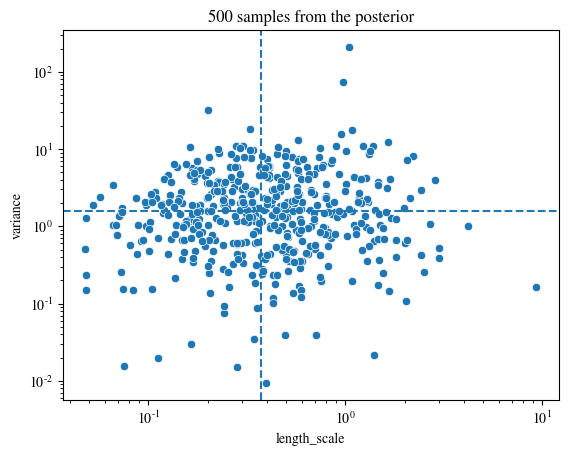

In [116]:
sns.scatterplot(data=df, x="length_scale", y="variance")
plt.xscale('log')
plt.yscale('log')
plt.title('500 samples from the posterior')
plt.axvline(df['length_scale'].median(), ls = '--')
plt.axhline(df['variance'].median(), ls = '--')



Use the obtained MCMC samples from the posterior to obtain estimates of mean $m(x^{∗})$ and variance $v(x^{∗})$ of $p(y^{∗}|x^{∗}, D)$ at a point $x^{∗} ∈ [−1, 1]$

#See https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes.ipynb#scrollTo=IYJ36MT_NLwR

In [130]:
posterior_kernel_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_kernel_var = mcmc.get_samples()["kernel.variance"]

In [133]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

In [134]:
## create RBF kernel function
import numpy as np

def RBF_kernel(X1, X2, l=torch.mean(posterior_kernel_ls).item(), sigma_f=torch.mean(posterior_kernel_var)):
    """
    The Gaussian kernel
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

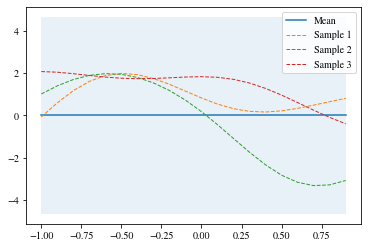

In [147]:
%matplotlib inline

# Finite number of points
X = np.arange(-1, 1, 0.1).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = RBF_kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu, cov, X, samples=samples)

In [148]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=torch.mean(posterior_kernel_ls).item(), sigma_f=torch.mean(posterior_kernel_var).item(), sigma_y=1e-4):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [164]:
np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)

array([[-4],
       [-3],
       [-2],
       [-1],
       [ 1]])

In [165]:
x = x.numpy()

In [166]:
x.reshape(-1, 1)

array([[-1. ],
       [-0.5],
       [ 0. ],
       [ 0.5],
       [ 1. ]], dtype=float32)

In [162]:
# Noise free training data
#X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
#Y_train = np.sin(X_train)

X_train = x.numpy().reshape(-1, 1)
Y_train = y.numpy()

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

TypeError: ignored